In [1]:
!pip install emoji
!pip install datasets transformers huggingface_hub
!apt-get install git-lfs
!pip install accelerate -U
!pip install fastText

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 993.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fastText: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199771 sha256=8dea11bd3d5cc99bbca4bf6cf8298b43fd8f1b9afd9e57765e17caceaf825793
  Stored in directory: 

In [ ]:
import os
os._exit(00)

In [1]:
import emoji
import re
import googleapiclient.discovery
import torch
import fasttext
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
from huggingface_hub import notebook_login

In [3]:
dev = ' '
huggy_log =' '
fast_text_model = fasttext.load_model('lid.176.ftz')
api_service_name = "youtube"
api_version = "v3"
DEVELOPER_KEY = dev
youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey=DEVELOPER_KEY)

In [4]:
def clean_text(text):
    allchars = [str for str in text.decode('utf-8')]
    emoji_list = [c for c in allchars if c in emoji.EMOJI_DATA]
    clean_text = ' '.join([str for str in text.decode('utf-8').split() if not any(i in str for i in emoji_list)])
    clean_text = re.sub('http[s]?://\S+', '', clean_text)
    if fast_text_model.predict(clean_text, k=1)[0][0] == '__label__en':
      return clean_text
    return ''

In [5]:
def getcomments(video):
  request = youtube.commentThreads().list(
      part="snippet",
      videoId=video,
      maxResults=100
      )
  comments = []
  response = request.execute()
  for item in response['items']:
      comment = item['snippet']['topLevelComment']['snippet']
      text = clean_text(comment['textOriginal'].lower().strip().encode('utf8'))
      if text != '':
        comments.append([
            comment['authorDisplayName'],
            comment['publishedAt'],
            comment['likeCount'],
            text,
            comment['videoId'],
        ])
  while (1 == 1):
    try:
     nextPageToken = response['nextPageToken']
    except KeyError:
     break
    nextPageToken = response['nextPageToken']
    nextRequest = youtube.commentThreads().list(part="snippet", videoId=video,
                                                maxResults=100, pageToken=nextPageToken)
    response = nextRequest.execute()
    for item in response['items']:
      comment = item['snippet']['topLevelComment']['snippet']
      text = clean_text(comment['textOriginal'].lower().strip().encode('utf8'))
      if text != '':
        comments.append([
            comment['authorDisplayName'],
            comment['publishedAt'],
            comment['likeCount'],
            text,
            comment['videoId'],
        ])

  df = pd.DataFrame(comments, columns=['author', 'updated_at', 'like_count',
                                        'text','video_id'])
  return df

In [6]:
df = getcomments('0VH9WCFV6XQ')
df

,author,updated_at,like_count,text,video_id
0,@HieuNguyen.contrai,2023-12-15T12:18:30Z,1,wowwwwwwwwwwwwwwwwwwww,0VH9WCFV6XQ
1,@troygoodwin5384,2023-12-15T07:59:51Z,1,nicolas cage done one similar,0VH9WCFV6XQ
2,@muhammadhumayl8323,2023-12-15T05:37:33Z,1,i just actually wanna watch this movie after w...,0VH9WCFV6XQ
3,@user-qz8zp1df1d,2023-12-15T01:34:58Z,0,nononoononononononononono beau me,0VH9WCFV6XQ
4,@ashleeorwin3442,2023-12-15T00:44:31Z,0,i absolutely loved the movie and the story lin...,0VH9WCFV6XQ
...,...,...,...,...,...
42155,@davidfaris6920,2023-06-27T14:59:57Z,0,first,0VH9WCFV6XQ
42156,@peanutbar015,2023-06-27T14:59:56Z,0,omg yasss,0VH9WCFV6XQ
42157,@ermset638,2023-06-27T14:59:56Z,0,yessss!!!!,0VH9WCFV6XQ
42158,@C-Lmemes,2023-06-27T14:59:52Z,1,omgggg,0VH9WCFV6XQ


In [7]:
torch.cuda.is_available()

True

In [8]:
imdb = load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [9]:
train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(10000))])
test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(1000))])
print(train_dataset[0])
print(test_dataset[0])

{'text': 'There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier\'s plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it\'s the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...', 'label': 1}
{'text': "<br /><br />When I unsuspectedly rented A Thousand Acres, I thought I was in for an entertaining King Lear story and of course Michelle Pfeiffer was in it, so what could go wrong?<br /><br />Very quickly, 

In [10]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [11]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=512)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [12]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [13]:
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment", num_labels=3)

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [14]:
def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions,
                                     references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"accuracy": accuracy, "f1": f1}

In [16]:
notebook_login(huggy_log)

In [17]:
repo_name = "finetuning-sentiment-roberta-model-10000-samples"

training_args = TrainingArguments(
    output_dir=repo_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    save_strategy="epoch",
    push_to_hub=True,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [18]:
trainer.train()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.264100
1000,0.163100


TrainOutput(global_step=1250, training_loss=0.20134169616699218, metrics={'train_runtime': 1843.8116, 'train_samples_per_second': 10.847, 'train_steps_per_second': 0.678, 'total_flos': 5168928869620992.0, 'train_loss': 0.20134169616699218, 'epoch': 2.0})

In [19]:
trainer.evaluate()

<ipython-input-14-594229443b8d>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")


{'eval_loss': 0.22689016163349152,
 'eval_accuracy': 0.937,
 'eval_f1': 0.9345794392523364,
 'eval_runtime': 33.0742,
 'eval_samples_per_second': 30.235,
 'eval_steps_per_second': 1.905,
 'epoch': 2.0}

In [20]:
trainer.push_to_hub()

events.out.tfevents.1702661309.e8379d7c9cc7.1458.1:   0%|          | 0.00/457 [00:00<?, ?B/s]

'https://huggingface.co/pryshlyak/finetuning-sentiment-roberta-model-10000-samples/tree/main/'

In [21]:
sentiment_model = pipeline(model="pryshlyak/finetuning-sentiment-roberta-model-10000-samples")

sentiment_model(["I love it", "I hate it"])

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

[{'label': 'LABEL_1', 'score': 0.9973956346511841},
 {'label': 'LABEL_0', 'score': 0.9980679154396057}]

In [22]:
def get_sentiment(df):
  list_comments = df["text"].astype(str).tolist()
  sentiments = []
  pos_score = 0
  neg_score = 0
  max_length = 256
  for i in range(0, len(list_comments)):
    sentiment = ''
    if len(list_comments[i]) > max_length:
      sentiment = sentiment_model(list_comments[i][:max_length])
    else:
      sentiment = sentiment_model(list_comments[i])
    if sentiment[0].get('label') == 'LABEL_0':
       sentiments.append('neg')
       if df['like_count'][i] > 0:
         neg_score += 1 * df['like_count'][i]
       else:
         neg_score += 1
    else:
       sentiments.append('pos')
       if df['like_count'][i] > 0:
         pos_score += 1 * df['like_count'][i]
       else:
         pos_score += 1
  return sentiments, pos_score, neg_score

In [23]:
sentiments, pos_score, neg_score = get_sentiment(df)
df['sentiments'] = sentiments
df

,author,updated_at,like_count,text,video_id,sentiments
0,@HieuNguyen.contrai,2023-12-15T12:18:30Z,1,wowwwwwwwwwwwwwwwwwwww,0VH9WCFV6XQ,neg
1,@troygoodwin5384,2023-12-15T07:59:51Z,1,nicolas cage done one similar,0VH9WCFV6XQ,pos
2,@muhammadhumayl8323,2023-12-15T05:37:33Z,1,i just actually wanna watch this movie after w...,0VH9WCFV6XQ,pos
3,@user-qz8zp1df1d,2023-12-15T01:34:58Z,0,nononoononononononononono beau me,0VH9WCFV6XQ,pos
4,@ashleeorwin3442,2023-12-15T00:44:31Z,0,i absolutely loved the movie and the story lin...,0VH9WCFV6XQ,pos
...,...,...,...,...,...,...
42155,@davidfaris6920,2023-06-27T14:59:57Z,0,first,0VH9WCFV6XQ,pos
42156,@peanutbar015,2023-06-27T14:59:56Z,0,omg yasss,0VH9WCFV6XQ,pos
42157,@ermset638,2023-06-27T14:59:56Z,0,yessss!!!!,0VH9WCFV6XQ,pos
42158,@C-Lmemes,2023-06-27T14:59:52Z,1,omgggg,0VH9WCFV6XQ,pos


In [24]:
df.to_csv('fnf_movie_comments_roberta.csv', encoding='utf-8', index=False)

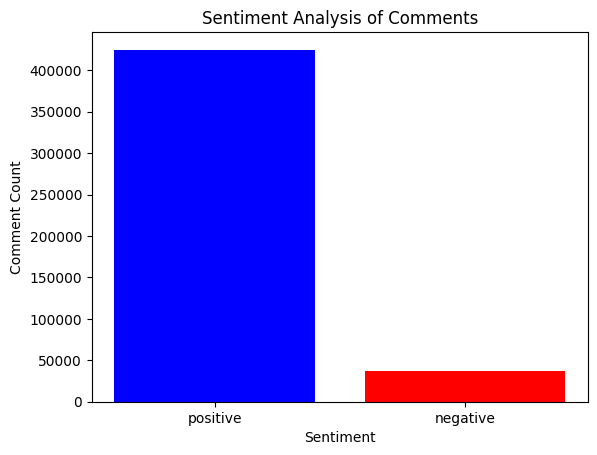

In [25]:
plt.bar(['positive', 'negative'], [pos_score, neg_score], color=['blue', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Comment Count')
plt.title('Sentiment Analysis of Comments')
plt.show()

In [27]:
print(pos_score)
print(neg_score)

424693
37063


In [26]:
df2 = getcomments('pBk4NYhWNMM')
df2

,author,updated_at,like_count,text,video_id
0,@spookygeek07,2023-12-15T14:28:48Z,1,i saw this movie and i absolutely adore it. i ...,pBk4NYhWNMM
1,@alexnclips6790,2023-12-15T14:00:05Z,0,how this got to a billion is beyond me,pBk4NYhWNMM
2,@kena1213,2023-12-15T07:54:47Z,0,kisses,pBk4NYhWNMM
3,@sev3n7z,2023-12-14T11:20:16Z,2,i'm not to sure what all the hurrah was about ...,pBk4NYhWNMM
4,@fredericoabiog3867,2023-12-14T08:02:41Z,1,i love this movie even i'm a boy,pBk4NYhWNMM
...,...,...,...,...,...
22318,@henrysheffield3998,2023-05-25T16:01:24Z,0,real,pBk4NYhWNMM
22319,@Blaze-zt5qm,2023-05-25T16:01:24Z,0,fiesta,pBk4NYhWNMM
22320,@mollypercocet1718,2023-05-25T16:01:13Z,0,first,pBk4NYhWNMM
22321,@Carnaaqe,2023-05-25T16:01:00Z,0,w,pBk4NYhWNMM


In [28]:
sentiments, pos_score, neg_score = get_sentiment(df2)

In [29]:
df2['sentiments'] = sentiments
df2

,author,updated_at,like_count,text,video_id,sentiments
0,@spookygeek07,2023-12-15T14:28:48Z,1,i saw this movie and i absolutely adore it. i ...,pBk4NYhWNMM,pos
1,@alexnclips6790,2023-12-15T14:00:05Z,0,how this got to a billion is beyond me,pBk4NYhWNMM,pos
2,@kena1213,2023-12-15T07:54:47Z,0,kisses,pBk4NYhWNMM,pos
3,@sev3n7z,2023-12-14T11:20:16Z,2,i'm not to sure what all the hurrah was about ...,pBk4NYhWNMM,neg
4,@fredericoabiog3867,2023-12-14T08:02:41Z,1,i love this movie even i'm a boy,pBk4NYhWNMM,pos
...,...,...,...,...,...,...
22318,@henrysheffield3998,2023-05-25T16:01:24Z,0,real,pBk4NYhWNMM,pos
22319,@Blaze-zt5qm,2023-05-25T16:01:24Z,0,fiesta,pBk4NYhWNMM,pos
22320,@mollypercocet1718,2023-05-25T16:01:13Z,0,first,pBk4NYhWNMM,pos
22321,@Carnaaqe,2023-05-25T16:01:00Z,0,w,pBk4NYhWNMM,pos


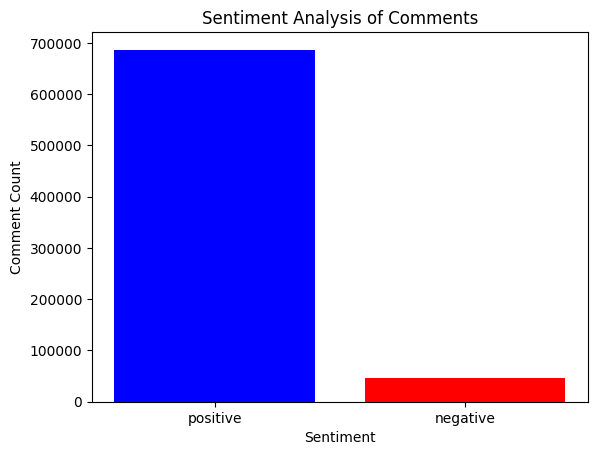

In [30]:
plt.bar(['positive', 'negative'], [pos_score, neg_score], color=['blue', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Comment Count')
plt.title('Sentiment Analysis of Comments')
plt.show()

In [31]:
df2.to_csv('barbie_movie_comments-roberta.csv', encoding='utf-8', index=False)

In [32]:
print(pos_score)
print(neg_score)

686873
45347


In [34]:
df3 = getcomments('uYPbbksJxIg')
df3

,author,updated_at,like_count,text,video_id
0,@Desertphile,2023-12-15T19:17:16Z,0,fading to black every three seconds is annoyin...,uYPbbksJxIg
1,@XSakuraBellsX,2023-12-15T12:01:12Z,1,i could not hear a word in the actual movie. c...,uYPbbksJxIg
2,@gamasatrio1892,2023-12-15T09:27:28Z,0,oppenheimer,uYPbbksJxIg
3,@zillsburyy1,2023-12-15T06:39:31Z,1,i did not like this. it was like watching fear...,uYPbbksJxIg
4,@jasonapplebaum9871,2023-12-14T21:38:00Z,0,greatest movie of all time. this inspired me t...,uYPbbksJxIg
...,...,...,...,...,...
20362,@xxxbrwxxxaleksanderhs1572,2023-05-08T07:03:05Z,1,shit,uYPbbksJxIg
20363,@alluarbind7248,2023-05-08T07:02:54Z,1,love u from nepal first comment,uYPbbksJxIg
20364,@LandonH117,2023-05-08T07:02:38Z,5,first edit: i just went to go see guardians of...,uYPbbksJxIg
20365,@elonmusknigachocolate,2023-05-08T07:02:28Z,8,this trailer alone is screaming over 8.5 imdb ...,uYPbbksJxIg


In [35]:
sentiments, pos_score, neg_score = get_sentiment(df3)

In [36]:
df3['sentiments'] = sentiments
df3

,author,updated_at,like_count,text,video_id,sentiments
0,@Desertphile,2023-12-15T19:17:16Z,0,fading to black every three seconds is annoyin...,uYPbbksJxIg,neg
1,@XSakuraBellsX,2023-12-15T12:01:12Z,1,i could not hear a word in the actual movie. c...,uYPbbksJxIg,neg
2,@gamasatrio1892,2023-12-15T09:27:28Z,0,oppenheimer,uYPbbksJxIg,pos
3,@zillsburyy1,2023-12-15T06:39:31Z,1,i did not like this. it was like watching fear...,uYPbbksJxIg,neg
4,@jasonapplebaum9871,2023-12-14T21:38:00Z,0,greatest movie of all time. this inspired me t...,uYPbbksJxIg,pos
...,...,...,...,...,...,...
20362,@xxxbrwxxxaleksanderhs1572,2023-05-08T07:03:05Z,1,shit,uYPbbksJxIg,neg
20363,@alluarbind7248,2023-05-08T07:02:54Z,1,love u from nepal first comment,uYPbbksJxIg,pos
20364,@LandonH117,2023-05-08T07:02:38Z,5,first edit: i just went to go see guardians of...,uYPbbksJxIg,pos
20365,@elonmusknigachocolate,2023-05-08T07:02:28Z,8,this trailer alone is screaming over 8.5 imdb ...,uYPbbksJxIg,pos


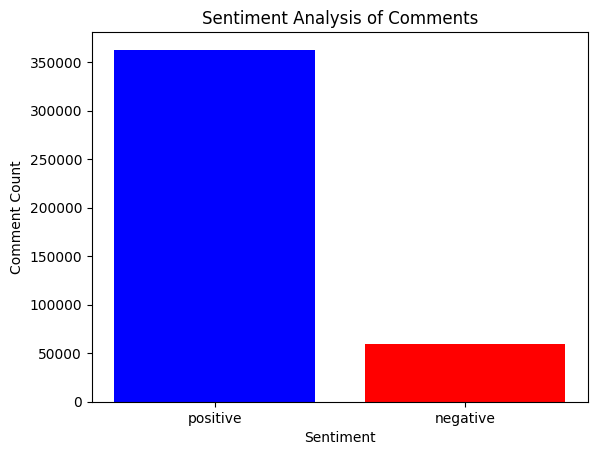

In [37]:
plt.bar(['positive', 'negative'], [pos_score, neg_score], color=['blue', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Comment Count')
plt.title('Sentiment Analysis of Comments')
plt.show()

In [38]:
df3.to_csv('oppenheimer_movie_comments_roberta.csv', encoding='utf-8', index=False)

In [ ]:
print(pos_score)
print(neg_score)

In [39]:
count = 0
for i in range(0, len(df['text'])):
  if df['sentiments'][i] == 'neg':
    print(df['text'][i])
    count += 1
print(count)

Показано результат, скорочений до останніх рядків (5000).
imagine just watching this and some 12 y/o just screams the entire movie, you know they ain't the real fnaf fans
can't comprehend the size of this w
oh heck naw i ain’t watching this cause this part: 2:14
i was so surprised to see this movie!!!! but i can't watch it 'cos i'm not a teen
tbh,i expected more,im kinda disappointed
this is one of those movies that’ll genuinely disappoint me after i watch it .
anyone else think the animatronics look like they're animated? just too much color, hoping they fix it.
aaaahhhhhhhhhhhhhhhhhhh
you will be disappointed watching this movie. beware.
ok why i understand cory deserved his part in the movie but where the hell in marks
disappointed that they spoiled springtrap appearance in the trailer, would've been nice to see him for the first time in the actual movie. at this point almost all the animatronics have been teased
if this doesnt exceed my high expectations im going to actually fuckin

In [40]:
count = 0
for i in range(0, len(df2['text'])):
  if df2['sentiments'][i] == 'neg':
    print(df2['text'][i])
    count += 1
print(count)

Показано результат, скорочений до останніх рядків (5000).
why?
i can’t believe ya’ll watched this movie lol
unbelievable ryan accepted to do this movie ,. not very masculine. weakening men, obedient ken ,....
per reviews this not a kid material movie ,..
where is the part where barbie nukes los alamos in pink glitter?
ryan gosling has a crooked nose. ken doesn't have a crooked nose. wonder why they picked him? a male model would have been a better choice.
sad comparison for the black ariel movie
looks like another woke man-hatting flop!!!!!!!!!!
i knew this movie was going to be men-hating, female-empowerment feminist trash!!!! lmao.
this may end some careers
not for kids
i didnt watch it yet but why is she getting arrested
why would they even make this movie, i just don't get it
the feminazis misandry movie
i don't know if anyone from warner brothers is reading this but i am so f****** mad...there is a conservative critic out there who gave a review with spoilers and didn't even say s

In [41]:
count = 0
for i in range(0, len(df3['text'])):
  if df3['sentiments'][i] == 'neg':
    print(df3['text'][i])
    count += 1
print(count)

Показано результат, скорочений до останніх рядків (5000).
when they unleashed this to hiroshima and nagasaki hatred on that time in wwii
who tf here because of the barbie-oppenheimer memes?
go ahead and give them the oscars now dammit!
what is this?
now i am become death, the destroyer of worlds. j. robert oppenheimer.
i ll say this life aint movie
and this is how evil started
if you put it on 1.25 speed you can hear how heavily auto-tuned the trailer is.
luckily there were only two war crimes committed with nuclear weapons till this day and not much more...
“now i am become death, the destroyer of worlds” - oppenheimer
on 6 and 9 august 1945, the united states detonated two atomic bombs over the japanese cities of hiroshima and nagasaki, respectively. the aerial bombings together killed between 129,000 and 226,000 people, most of whom were civilians...
war never brings peace
he wants to be taken seriously and win an oscar like nolan spielberg, give this friend his oscar so he doesn't 